# IMPORT, CONFIG

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchmetrics.functional import f1_score, recall, accuracy
from torchinfo import summary

import os
import random
import time
from tqdm import tqdm
import pickle
import re
import gensim
import random
from collections import defaultdict
from collections import Counter
from textwrap import wrap

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

C:\Programs\miniconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.random.manual_seed(RANDOM_SEED)
torch.cuda.random.manual_seed_all(RANDOM_SEED)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
DEVICE

device(type='cuda')

# LOAD DATA

In [6]:
with open('ohsumed_dataset.pkl','rb') as ohsumed_file:
     source = pickle.load(ohsumed_file)

In [10]:
source

,texts,Y
0,Haemophilus influenzae meningitis with prolong...,0
1,Augmentation mentoplasty using Mersilene mesh....,0
2,Multiple intracranial mucoceles associated wit...,0
3,Replacement of an aortic valve cusp after neon...,0
4,Mucosal intussusception to avoid ascending cho...,0
...,...,...
56979,Ionized calcium in blood: studies on patients ...,22
56980,Effects of immediate postoperative enteral nut...,22
56981,Effects of enteral fat emulsion on fat absorpt...,22
56982,Inhibition of early atherogenesis in transgeni...,22


In [11]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56984 entries, 0 to 56983
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   56984 non-null  object
 1   Y       56984 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 890.5+ KB


In [13]:
target_column = 'Y'
data = source

In [14]:
data

,texts,Y
0,Haemophilus influenzae meningitis with prolong...,0
1,Augmentation mentoplasty using Mersilene mesh....,0
2,Multiple intracranial mucoceles associated wit...,0
3,Replacement of an aortic valve cusp after neon...,0
4,Mucosal intussusception to avoid ascending cho...,0
...,...,...
56979,Ionized calcium in blood: studies on patients ...,22
56980,Effects of immediate postoperative enteral nut...,22
56981,Effects of enteral fat emulsion on fat absorpt...,22
56982,Inhibition of early atherogenesis in transgeni...,22


In [15]:
train_df, dev_df = train_test_split(source, test_size=0.2, random_state=RANDOM_SEED,stratify=source[target_column].to_list())

In [16]:
dev_df, test_df = train_test_split(dev_df, test_size=0.5, random_state=RANDOM_SEED,stratify=dev_df[target_column].to_list())

In [17]:
len(train_df), len(dev_df), len(test_df)

(45587, 5698, 5699)

# PREPROCESSING

We initialize word vectors with the publicly available
word2vec vectors that are pre-trained using
about 100B words from the Google News Dataset.
The dimensionality of the word vectors is 300. We
also initialize the word vector for the unknown
words from the uniform distribution [-0.25, 0.25].
We then fine-tune the word vectors along with other
model parameters during training.

In [18]:
EMBEDDING_SIZE = 300

In [19]:
class MyTokenizer():
    class Encoding:
        def __init__(self):
            super().__init__()
            tokens = list()
            ids = list()        
            
    def __init__(self):
        self.index2token = list()
        self.token2index = dict()
        self.token2count = Counter()
        self.encoding = MyTokenizer.Encoding()
        self.reset()

    def preprocess_token(self,token):
        token = re.sub(r'\d+[\,\.]?\d+','',token)
        token = re.sub(r'[\.\,\"\'\;\:\)\]\(\[\?\!\-\+]{1,}$','',token)
        token = re.sub(r'^[\.\,\(\[\"\'\;\:\)\]\?\!\-\+]{1,}','',token)
        token = token.replace('\n','')
        if token != "":
            return token
        
    def add_sentence(self, sentence):
        for token in self.encode(sentence).tokens:
            self.add_token(token)

    def add_token(self, token):
        if token not in self.token2index:
            self.token2index[token] = len(self.index2token)
            self.token2count[token] += 1
            self.index2token.append(token)
        else:
            self.token2count[token] += 1
    
    def has_token(self, token) -> bool:
        return token in self.token2index

    def add_texts(self):
        sents_texts = train_df.texts.to_list()
        for sent in sents_texts:
            self.add_sentence(sent)

    def token_to_id(self, token):
        if token in self.token2index:
            return self.token2index[token]
        return self.token2index["<unk>"]

    def id_to_token(self, id_):
        if id_ in self.index2token:
            return self.index2token[id_]
        print('Нет такого id в словаре!')
    
    def is_empty(self):
        empty_size = 4
        return self.size() <= empty_size

    def shrink(self, n):
        # для сокращения словаря (выбирает n самых частых слов) (подаётся n)
        best_tokens = self.token2count.most_common(n)
        self.reset()
        for token, count in best_tokens:
            self.add_token(token)
            self.token2count[token] = count

    def reset(self):
        self.token2count = Counter()
        self.index2token = ["<PAD>", "<UNK>"]
        self.token2index = {token: index for index, token in enumerate(self.index2token)}

    def get_vocab(self):
        return self.token2index
    
    def get_vocab_size(self):
        return len(self.index2token)
        
    def encode(self, text: str): # sentence: str
        text = text.lower().strip()
        
        self.encoding.tokens = text.split(' ')
        self.encoding.tokens = [self.preprocess_token(token) for token in self.encoding.tokens]
        return self.encoding

    def decode(self, ids: torch.LongTensor):
        return print([self.index2token[id_] for id_ in ids].join(' '))

In [20]:
tokenizer = MyTokenizer()

In [21]:
tokenizer.add_texts()
#tokenizer.shrink(10000)

In [22]:
# df_count_word = pd.DataFrame({'token':tokenizer.token2count.keys(),'count':tokenizer.token2count.values()})

In [23]:
# for token in set(df_count_word[df_count_word['count'] == 1].token.values):
#     del tokenizer.token2index[token]
#     tokenizer.index2token.remove(token)
#     del tokenizer.token2count[token]

In [24]:
# del df_count_word

In [25]:
# tokenizer.token2index = dict(zip(tokenizer.token2index.keys(),range(len(tokenizer.token2index))))

In [26]:
tokenizer.token2index

{'<PAD>': 0,
 '<UNK>': 1,
 'correlation': 2,
 'of': 3,
 'the': 4,
 'blind': 5,
 'spot': 6,
 'size': 7,
 'to': 8,
 'area': 9,
 'optic': 10,
 'disk': 11,
 'and': 12,
 'parapapillary': 13,
 'atrophy': 14,
 'we': 15,
 'evaluated': 16,
 'relationship': 17,
 'between': 18,
 'using': 19,
 'kinetic': 20,
 'goldmann': 21,
 'perimetry': 22,
 'in': 23,
 None: 24,
 'patients': 25,
 'with': 26,
 'open-angle': 27,
 'glaucoma': 28,
 'normal': 29,
 'subjects': 30,
 'was': 31,
 'correlated': 32,
 'significantly': 33,
 'total': 34,
 'peripapillary': 35,
 'scleral': 36,
 'ring': 37,
 'chorioretinal': 38,
 'zone': 39,
 'beta': 40,
 'a': 41,
 'visible': 42,
 'sclera': 43,
 'attributed': 44,
 'an': 45,
 'absolute': 46,
 'scotoma': 47,
 'alpha': 48,
 'irregular': 49,
 'pigmentation': 50,
 'relative': 51,
 'larger': 52,
 'glaucomatous': 53,
 'eyes': 54,
 'than': 55,
 'which': 56,
 'corresponded': 57,
 'intrapapillary': 58,
 'region': 59,
 'nerve': 60,
 'head': 61,
 'included': 62,
 'significant': 63,
 'differ

In [27]:
tokenizer.index2token

['<PAD>',
 '<UNK>',
 'correlation',
 'of',
 'the',
 'blind',
 'spot',
 'size',
 'to',
 'area',
 'optic',
 'disk',
 'and',
 'parapapillary',
 'atrophy',
 'we',
 'evaluated',
 'relationship',
 'between',
 'using',
 'kinetic',
 'goldmann',
 'perimetry',
 'in',
 None,
 'patients',
 'with',
 'open-angle',
 'glaucoma',
 'normal',
 'subjects',
 'was',
 'correlated',
 'significantly',
 'total',
 'peripapillary',
 'scleral',
 'ring',
 'chorioretinal',
 'zone',
 'beta',
 'a',
 'visible',
 'sclera',
 'attributed',
 'an',
 'absolute',
 'scotoma',
 'alpha',
 'irregular',
 'pigmentation',
 'relative',
 'larger',
 'glaucomatous',
 'eyes',
 'than',
 'which',
 'corresponded',
 'intrapapillary',
 'region',
 'nerve',
 'head',
 'included',
 'significant',
 'difference',
 'results',
 'multicenter',
 'studies',
 'digoxin-specific',
 'antibody',
 'fragments',
 'managing',
 'digitalis',
 'intoxication',
 'pediatric',
 'population',
 'toxicity',
 'continues',
 'be',
 'problem',
 'for',
 'undergoing',
 'therapy

In [28]:
tokenizer.token2count

Counter({'correlation': 2349,
         'of': 380822,
         'the': 376680,
         'blind': 334,
         'spot': 68,
         'size': 1969,
         'to': 135973,
         'area': 2409,
         'optic': 623,
         'disk': 147,
         'and': 255414,
         'parapapillary': 12,
         'atrophy': 551,
         'we': 20212,
         'evaluated': 3360,
         'relationship': 2200,
         'between': 13483,
         'using': 6960,
         'kinetic': 113,
         'goldmann': 15,
         'perimetry': 64,
         'in': 248178,
         None: 212626,
         'patients': 99795,
         'with': 137073,
         'open-angle': 67,
         'glaucoma': 443,
         'normal': 11689,
         'subjects': 7085,
         'was': 85019,
         'correlated': 2364,
         'significantly': 10602,
         'total': 6174,
         'peripapillary': 26,
         'scleral': 134,
         'ring': 220,
         'chorioretinal': 52,
         'zone': 524,
         'beta': 1780,
         'a'

In [29]:
VOCAB_SIZE = tokenizer.get_vocab_size()
VOCAB_SIZE

85325

In [30]:
embedding_matrix = torch.zeros(VOCAB_SIZE, EMBEDDING_SIZE)
embedding_matrix.shape

torch.Size([85325, 300])

In [31]:
Word2Vec = gensim.models.KeyedVectors.load_word2vec_format('./test_models/GoogleNews-vectors-negative300.bin', binary=True)  

In [32]:
for index, word in zip(tokenizer.token2index.values(),tokenizer.token2index.keys()):
    try:
        embedding_matrix[index] = torch.from_numpy(Word2Vec.get_vector(word).copy())
    except:
        embedding_matrix[index] = (-0.25 - 0.25) * torch.rand(EMBEDDING_SIZE) + 0.25

In [33]:
del Word2Vec

In [34]:
embedding_matrix[tokenizer.token2index['<PAD>']] = torch.zeros(EMBEDDING_SIZE)

In [35]:
embedding_matrix[tokenizer.token2index['<UNK>']] = (-0.25 - 0.25) * torch.rand(EMBEDDING_SIZE) + 0.25

# DATASET

First, we usemaxlen to denote the maximum length
of the sentence in the training set. As the convolution
layer in our model requires fixed-length input,
we pad each sentence that has a length less
than maxlen with special symbols at the end that
indicate the unknown words. For a sentence in the
test dataset, we pad sentences that are shorter than
maxlen in the same way, but for sentences that
have a length longer than maxlen, we simply cut
extra words at the end of these sentences to reach
maxlen.

In [36]:
MAX_LEN = train_df['texts'].apply(lambda x: len(tokenizer.encode(x).tokens)).max()
MAX_LEN

596

In [37]:
class OhsumedDataset(Dataset):

    def __init__(self, dataset, tokenizer, device):
        self.dataset = dataset['texts'].values
        self.token2index = tokenizer.token2index
        self.length = dataset.shape[0]
        self.target = dataset[target_column].values
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        ids = []
        for token in tokenizer.encode(self.dataset[index]).tokens:
            if token in self.token2index:
                ids.append(self.token2index[token])
            else:
                ids.append(self.token2index['<UNK>'])
        y = self.target[index]
        return ids, y    

    def collate_fn(self, batch):
        input_ids, y = list(zip(*batch)) # zip делает кортёжи соотв. эл-в и они записываются в list
        MAX_LEN_BATCH = max(map(len,input_ids))
        padded_ids = torch.empty((len(batch), MAX_LEN_BATCH), dtype=torch.long)
        for idx, ids in enumerate(input_ids):
            to_pad = MAX_LEN_BATCH - len(ids)
            padded_ids[idx] = torch.cat((torch.LongTensor(ids), torch.zeros(to_pad)))
        padded_ids = padded_ids.to(self.device)
        labels = torch.LongTensor(y).to(self.device)
        return padded_ids, labels      
    
#     def collate_fn(self, batch):
#         input_ids, y = list(zip(*batch)) # zip делает кортёжи соотв. эл-в и они записываются в list
#         padded_ids = torch.empty((len(batch), MAX_LEN), dtype=torch.long)
#         for idx, ids in enumerate(input_ids):
#             if len(ids) <= MAX_LEN:
#                 to_pad = MAX_LEN - len(ids)
#                 padded_ids[idx] = torch.cat((torch.LongTensor(ids), torch.zeros(to_pad)))
#             else:
#                 padded_ids[idx] = torch.LongTensor(ids[:MAX_LEN])
#         padded_ids = padded_ids.to(self.device)
#         labels = torch.LongTensor(y).to(self.device)
#         return padded_ids, labels

In [38]:
BATCH_SIZE = 512

In [39]:
train_dataset = OhsumedDataset(train_df, tokenizer, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=BATCH_SIZE)

In [40]:
dev_dataset = OhsumedDataset(dev_df, tokenizer, DEVICE)
dev_sampler = SequentialSampler(dev_dataset)
dev_iterator = DataLoader(dev_dataset, collate_fn = dev_dataset.collate_fn, sampler=dev_sampler, batch_size=BATCH_SIZE)

In [41]:
test_dataset = OhsumedDataset(test_df, tokenizer, DEVICE)
test_sampler = SequentialSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=BATCH_SIZE)

# Model

1) dp=0.0 1conv (stride=ks) out_lin filter=150 rnn=150 ks=5 (with weightloss) 0.16840985213699003

2) dp=0.0 1conv (stride=ks) out_lin filter=150 rnn=150 ks=3 (with weightloss) 0.2057123525939034

3) dp=0.5 1conv (stride=ks) out_lin filter=150 rnn=150 ks=3 (with weightloss)  0.13841512268785577

4) dp_emb=0.5 1conv (stride=ks) out_lin filter=150 rnn=150 ks=3 (with weightloss) epoch40 0.2260764092872208

#### Broadly speaking, to reduce overfitting, you can:
#### increase regularization
#### reduce model complexity
#### perform early stopping
#### increase training data

For regularization, we employ two commonly used
techniques: dropout (Hinton et al., 2012) and L2
weight regularization. We apply dropout to prevent
co-adaptation. In our model, we either apply
dropout to word vectors before feeding the sequence
of words into the convolutional layer or to the output
of LSTM before the softmax layer. The L2 regularization
is applied to the weight of the softmax layer.

For SST, the number of filters of length 3 is set to
be 150 and the memory dimension of LSTM is set
to be 150, too. The word vector layer and the LSTM
layer are dropped out with a probability of 0.5.

We also add L2 regularization
with a factor of 0.001 to the weights in the softmax
layer for both tasks.

For text classification, we regard the output of the
hidden state at the last time step of LSTM as the
document representation and we add a softmax layer
on top. We train the entire model by minimizing
the cross-entropy error.

We employ stochastic
gradient descent (SGD) to learn the model
parameters and adopt the optimizer RMSprop.

In [42]:
# import gc
# #del model
# torch.cuda.synchronize()
# torch.cuda.empty_cache()
# gc.collect()

In [43]:
embedding_matrix

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2053,  0.0242, -0.1100,  ...,  0.1143, -0.1408,  0.1299],
        [ 0.2080, -0.2598, -0.1982,  ..., -0.2656, -0.0006,  0.2021],
        ...,
        [-0.1496,  0.1075,  0.0919,  ..., -0.0197,  0.1381, -0.0049],
        [ 0.0439, -0.1534, -0.2331,  ...,  0.1696,  0.2059,  0.2221],
        [ 0.1914,  0.0854,  0.3555,  ..., -0.1904, -0.0018, -0.0593]])

In [44]:
class C_LSTM(nn.Module): # делаем свёртки на векторах
    def __init__(self, vocab_size, embed_size, hidden_size_cnn, kernel_size, stride, hidden_size_rnn, num_classes): # может быть словосочетания из 3 слов содержат достаточную информацию для классификации текста (например, по токсичности (3 слова грубых))
        super().__init__()
        
        self.embeddings = nn.Embedding.from_pretrained(embedding_matrix,freeze=False,padding_idx=0)
        #self.embeddings = nn.Embedding(vocab_size, embed_size, 0)

        self.cnn = nn.Conv1d(embed_size, hidden_size_cnn, kernel_size, stride) # (на выходе batch_size x hiden_size x seq_le1) (размерность ядра - embed_size x kernel_size)
        
        self.rnn = nn.LSTM(input_size=hidden_size_cnn, hidden_size=hidden_size_rnn, batch_first=True)
        
        self.linear = nn.Linear(hidden_size_rnn, num_classes)

        self.dropout = nn.Dropout(0.5)

        self.softmax = nn.Softmax(-1)

    def forward(self, inp): # (batch_size, seq_len)
#         print('inp.shape',inp.shape)
        emb = self.embeddings(inp)  # (batch_size, seq_len, embed_size)
#         print('emb.shape',emb.shape)
        emb_perm = emb.permute(0, 2, 1) # (batch_size, embed_size, seq_len)
#         print('emb_perm.shape',emb_perm.shape)
        emb_perm_dp = self.dropout(emb_perm) # (batch_size, embed_size, seq_len)
#         print('emb_perm_dp.shape',emb_perm_dp.shape)
        emb_cnn = F.relu(self.cnn(emb_perm_dp)) # (batch_size, embed_size, seq_len*) (N,C_in,L_in) -> (N,C_out,L_out)
#         print('emb_cnn.shape',emb_cnn.shape)
        emb_cnn_perm = emb_cnn.permute(0, 2, 1) # (batch_size, seq_len*, embed_size)
#         print('emb_cnn_perm.shape',emb_cnn_perm.shape)
        output_rnn, (hidden_rnn, cell_rnn) = self.rnn(emb_cnn_perm)
        # (N,L,H_in) -> (N,L,H_out), ((1,N,H), (1,N,H_cell))
        #  (batch_size, seq_len*,hidden_size_rnn), ((1, batch_size, hidden_size_rnn), (1, batch_size, hidden_size_rnn))
#         print('output_rnn.shape',output_rnn.shape)
#         print('hidden_rnn.shape',hidden_rnn.shape)
#         print('cell_rnn.shape',cell_rnn.shape)
#         emb_rnn_dp = self.dropout(hidden_rnn.squeeze(0)) # (batch_size, hidden_size_rnn)
#         print('emb_rnn_dp.shape',emb_rnn_dp.shape)
        out_lin = self.linear(hidden_rnn.squeeze(0)) # (batch_size, num_classes)
#         print('out_lin.shape',out_lin.shape)
#         print('-'*20)
        #pred = self.softmax(out_lin) # (batch_size, num_classes)
        #print('pred',pred)
        return out_lin
    
    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [45]:
KERNEL_SIZE = 3
STRIDE = 3
HIDDEN_SIZE_CNN = 150
HIDDEN_SIZE_RNN = 150
L2_FACTOR = 0.001
NUM_CLASSES = len(set(data[target_column].values))

In [46]:
NUM_EPOCHS = 30

In [47]:
model = C_LSTM(VOCAB_SIZE,EMBEDDING_SIZE, HIDDEN_SIZE_CNN, KERNEL_SIZE, STRIDE, HIDDEN_SIZE_RNN, NUM_CLASSES)
#optimizer = optim.RMSprop(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.005)
#weight_loss = torch.FloatTensor((1-data.groupby(target_column).Y.count()/len(data)).to_list())
criterion = nn.CrossEntropyLoss()

In [48]:
summary(model)

Layer (type:depth-idx)                   Param #
C_LSTM                                   --
├─Embedding: 1-1                         25,597,500
├─Conv1d: 1-2                            135,150
├─LSTM: 1-3                              181,200
├─Linear: 1-4                            3,473
├─Dropout: 1-5                           --
├─Softmax: 1-6                           --
Total params: 25,917,323
Trainable params: 25,917,323
Non-trainable params: 0

In [49]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

# TRAIN

In [50]:
train_losses = []
dev_losses = []
train_f1s = []
dev_f1s = []

best_f1 = 0

model_parameters = tuple(model.parameters())

for e in range(NUM_EPOCHS):
    train_epoch_loss = 0
    train_epoch_metric = 0
    model.train()
    print(f'\nstarting Epoch {e}')
    print('Training...')
    for i, (texts, labels) in enumerate(train_iterator):
        optimizer.zero_grad()
        prediction = model(texts)
        loss = criterion(prediction, labels)
        
        l2_parameters = [model_parameters[-2].view(-1), model_parameters[-1].view(-1)] # linear_weight, linear_bias
        loss += L2_FACTOR * model.compute_l2_loss(torch.cat(l2_parameters))
        
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_batch_metric = f1_score(prediction.long().detach().cpu().argmax(-1), labels.long().detach().cpu(), average='macro')
        train_epoch_metric += train_batch_metric
        if not (i + 1) % int(len(train_iterator)/5):
            print(f'Train loss: {train_epoch_loss/(i+1)}, Train f1: {train_epoch_metric/(i+1)}')

    train_f1, train_loss = train_epoch_metric / len(train_iterator), train_epoch_loss / len(train_iterator)
    train_losses.append(train_loss)
    train_f1s.append(train_f1)
    
    print('\nEvaluating on dev...')
    dev_epoch_loss = 0
    dev_epoch_metric = 0
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(dev_iterator): 
            optimizer.zero_grad()
            prediction = model(texts)
            loss = criterion(prediction, labels)
            dev_epoch_loss += loss.item()
            dev_batch_metric = f1_score(prediction.long().detach().cpu().argmax(-1), labels.long().detach().cpu(), average='macro')
            dev_epoch_metric += dev_batch_metric

            if not (i + 1) % int(len(dev_iterator)/5):
                print(f'Dev loss: {dev_epoch_loss/(i+1)}, Dev f1: {dev_epoch_metric/(i+1)}')
    
    dev_f1, dev_loss = dev_epoch_metric / len(dev_iterator), dev_epoch_loss / len(dev_iterator)
    dev_losses.append(dev_loss)
    dev_f1s.append(dev_f1)
    
    if dev_f1 > best_f1:
        best_f1 = dev_f1
        torch.save(
            model.state_dict(), "BEST_C-LSTM_Ohsumed.pt"
        )


starting Epoch 0
Training...
Train loss: 2.890945633252462, Train f1: 0.008605252022587844
Train loss: 2.8635785977045694, Train f1: 0.008961820706921308
Train loss: 2.855542363943877, Train f1: 0.009245648034018453
Train loss: 2.850036379363802, Train f1: 0.00913987651399886
Train loss: 2.841356478797065, Train f1: 0.009479946895293427

Evaluating on dev...
Dev loss: 2.775032639503479, Dev f1: 0.00937177328295696
Dev loss: 2.7973562479019165, Dev f1: 0.00894001360244173
Dev loss: 2.8203067779541016, Dev f1: 0.008613606038156352
Dev loss: 2.8241566717624664, Dev f1: 0.008662093905148716
Dev loss: 2.827375626564026, Dev f1: 0.008903884458321538
Dev loss: 2.8228667775789895, Dev f1: 0.00871739387347348

starting Epoch 1
Training...
Train loss: 2.8292344411214194, Train f1: 0.01099048600785464
Train loss: 2.830104516612159, Train f1: 0.009950473578173517
Train loss: 2.8266967358412565, Train f1: 0.009825052904399821
Train loss: 2.8270888295438557, Train f1: 0.009635404565051067
Train los

Dev loss: 2.417587161064148, Dev f1: 0.07700618003056431
Dev loss: 2.4591403007507324, Dev f1: 0.07115410095769528
Dev loss: 2.484634836514791, Dev f1: 0.07056376605484269
Dev loss: 2.4836195409297943, Dev f1: 0.06826873441992316
Dev loss: 2.4845687627792357, Dev f1: 0.06867172861058388
Dev loss: 2.4833762645721436, Dev f1: 0.06985231231766222

starting Epoch 12
Training...
Train loss: 2.4150696330600314, Train f1: 0.07697117965487035
Train loss: 2.4102063642607794, Train f1: 0.08048692290467235
Train loss: 2.4105511329792164, Train f1: 0.08445270341610112
Train loss: 2.4049644238419003, Train f1: 0.08551006366822222
Train loss: 2.399193289544847, Train f1: 0.08779602412377738

Evaluating on dev...
Dev loss: 2.354274034500122, Dev f1: 0.09334978814283924
Dev loss: 2.399751663208008, Dev f1: 0.08866573746064893
Dev loss: 2.4174147049585977, Dev f1: 0.09083221971527328
Dev loss: 2.4199059009552, Dev f1: 0.08995397237657463
Dev loss: 2.420515036582947, Dev f1: 0.08963338099922066
Dev loss

Train loss: 1.8493825285523027, Train f1: 0.27430993268845866
Train loss: 1.8484632323185604, Train f1: 0.27156647101113734
Train loss: 1.845965584119161, Train f1: 0.27032088101825563

Evaluating on dev...
Dev loss: 2.183375120162964, Dev f1: 0.20109443085623446
Dev loss: 2.193885624408722, Dev f1: 0.19252867422651318
Dev loss: 2.2078592777252197, Dev f1: 0.19890189162428007
Dev loss: 2.218406707048416, Dev f1: 0.19757565219501716
Dev loss: 2.222593092918396, Dev f1: 0.19927902146432044
Dev loss: 2.2324891885121665, Dev f1: 0.18913553625596116

starting Epoch 24
Training...
Train loss: 1.8111491534445021, Train f1: 0.281049530191736
Train loss: 1.7987141907215118, Train f1: 0.284245679193333
Train loss: 1.7962277708230194, Train f1: 0.28657924550309205
Train loss: 1.7973158756891887, Train f1: 0.28589367732790805
Train loss: 1.8042008002599081, Train f1: 0.2851676975767438

Evaluating on dev...
Dev loss: 2.1799975633621216, Dev f1: 0.20114037663371775
Dev loss: 2.1843045949935913, Dev

In [56]:
model_parameters = tuple(model.parameters())

for e in range(NUM_EPOCHS-21):
    train_epoch_loss = 0
    train_epoch_metric = 0
    model.train()
    print(f'\nstarting Epoch {e+31}')
    print('Training...')
    for i, (texts, labels) in enumerate(train_iterator):
        optimizer.zero_grad()
        prediction = model(texts)
        loss = criterion(prediction, labels)
        
        l2_parameters = [model_parameters[-2].view(-1), model_parameters[-1].view(-1)] # linear_weight, linear_bias
        loss += L2_FACTOR * model.compute_l2_loss(torch.cat(l2_parameters))
        
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_batch_metric = f1_score(prediction.long().detach().cpu().argmax(-1), labels.long().detach().cpu(), average='macro')
        train_epoch_metric += train_batch_metric
        if not (i + 1) % int(len(train_iterator)/5):
            print(f'Train loss: {train_epoch_loss/(i+1)}, Train f1: {train_epoch_metric/(i+1)}')

    train_f1, train_loss = train_epoch_metric / len(train_iterator), train_epoch_loss / len(train_iterator)
    train_losses.append(train_loss)
    train_f1s.append(train_f1)
    
    print('\nEvaluating on dev...')
    dev_epoch_loss = 0
    dev_epoch_metric = 0
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(dev_iterator): 
            optimizer.zero_grad()
            prediction = model(texts)
            loss = criterion(prediction, labels)
            dev_epoch_loss += loss.item()
            dev_batch_metric = f1_score(prediction.long().detach().cpu().argmax(-1), labels.long().detach().cpu(), average='macro')
            dev_epoch_metric += dev_batch_metric

            if not (i + 1) % int(len(dev_iterator)/5):
                print(f'Dev loss: {dev_epoch_loss/(i+1)}, Dev f1: {dev_epoch_metric/(i+1)}')
    
    dev_f1, dev_loss = dev_epoch_metric / len(dev_iterator), dev_epoch_loss / len(dev_iterator)
    dev_losses.append(dev_loss)
    dev_f1s.append(dev_f1)
    
    if dev_f1 > best_f1:
        best_f1 = dev_f1
        torch.save(
            model.state_dict(), "BEST_C-LSTM_Ohsumed.pt"
        )


starting Epoch 31
Training...
Train loss: 1.6851460933685303, Train f1: 0.3408155436549806
Train loss: 1.6944665378994412, Train f1: 0.33630779553973833
Train loss: 1.6850611059753984, Train f1: 0.33850944437047725
Train loss: 1.6806833975844913, Train f1: 0.3408513633130456
Train loss: 1.6790065526962281, Train f1: 0.3421613511394603

Evaluating on dev...
Dev loss: 2.1775087118148804, Dev f1: 0.22235139330420478
Dev loss: 2.198720395565033, Dev f1: 0.2160922663444149
Dev loss: 2.2015539010365806, Dev f1: 0.22033399011849567
Dev loss: 2.214218705892563, Dev f1: 0.21862745070359618
Dev loss: 2.220599627494812, Dev f1: 0.22199891772971236
Dev loss: 2.218158702055613, Dev f1: 0.21986855817905968

starting Epoch 32
Training...
Train loss: 1.6591836147838168, Train f1: 0.35518068260228675
Train loss: 1.6733155979050531, Train f1: 0.3467184716595644
Train loss: 1.668726060125563, Train f1: 0.3469232923096648
Train loss: 1.6608487003379397, Train f1: 0.34870045392445204
Train loss: 1.6689941

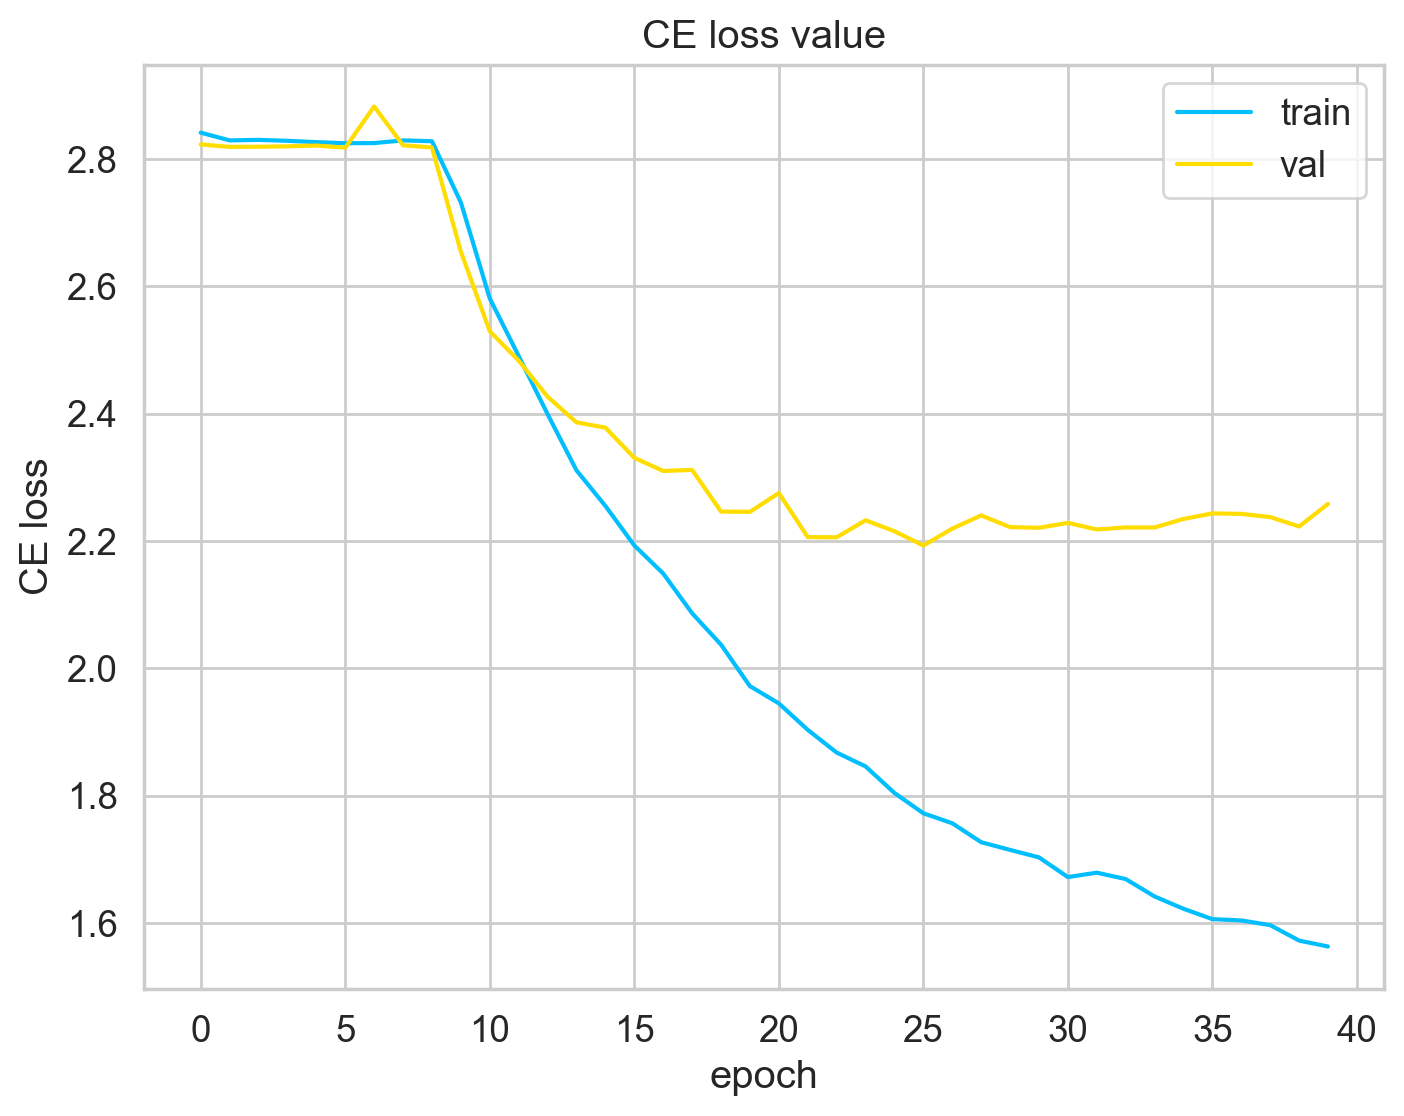

In [57]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(dev_losses)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

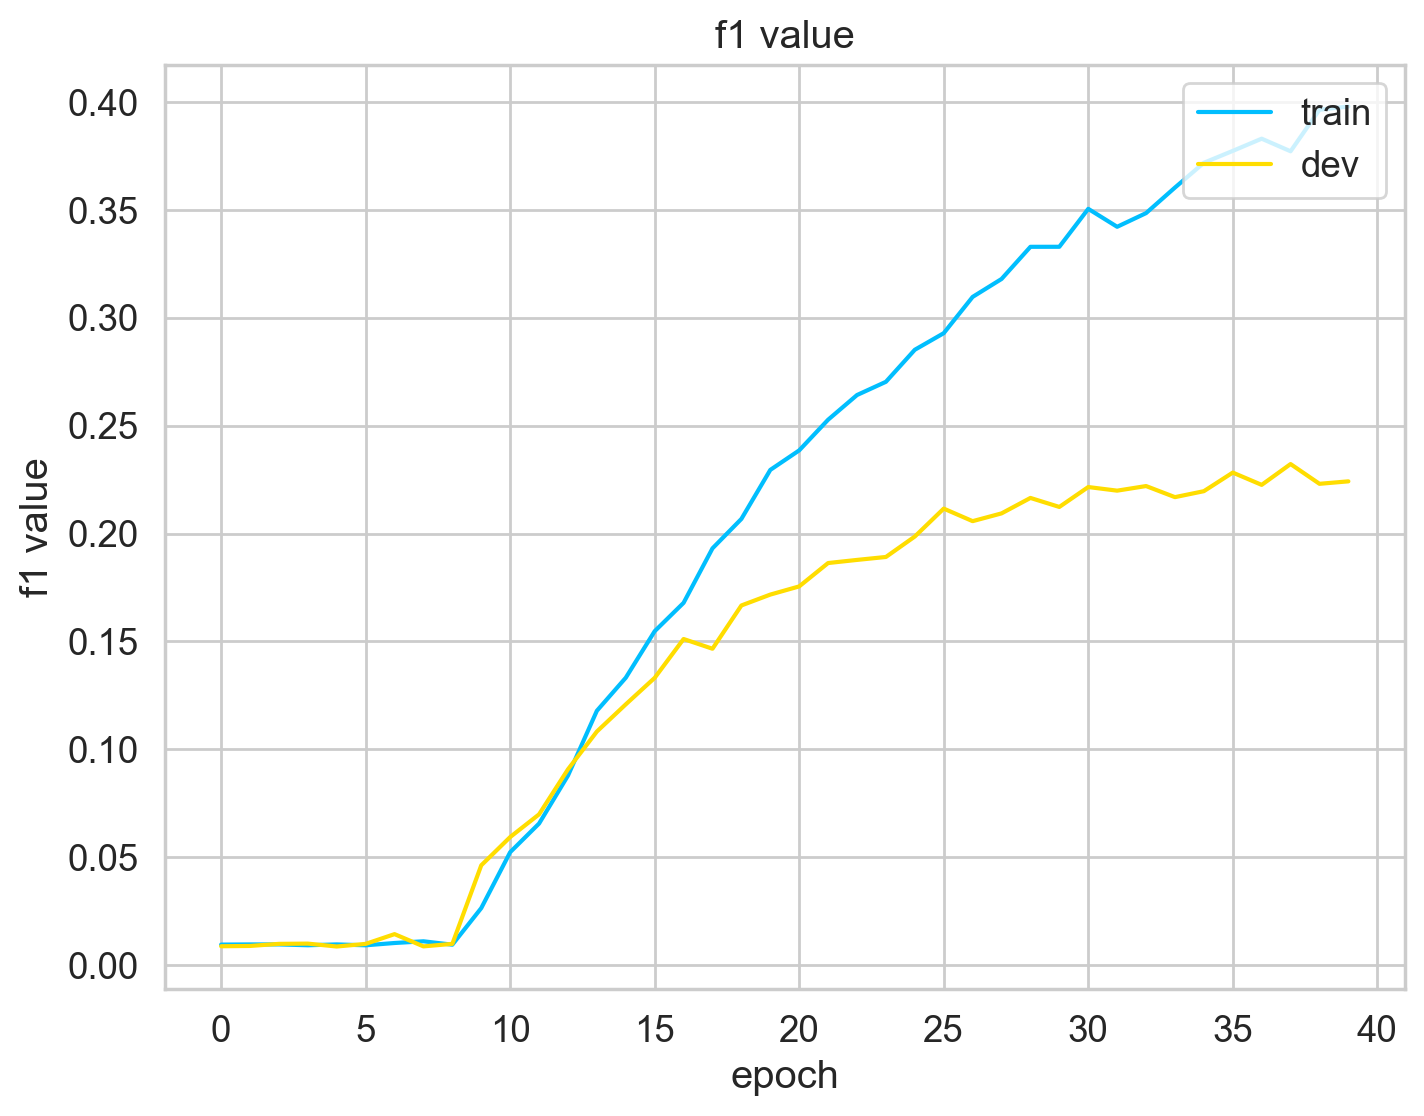

In [58]:
import matplotlib.pyplot as plt
plt.plot(train_f1s)
plt.plot(dev_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [59]:
best_params = torch.load("BEST_C-LSTM_Ohsumed.pt")
best_params

OrderedDict([('embeddings.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [-0.2053,  0.0242, -0.1100,  ...,  0.1143, -0.1408,  0.1299],
                      [ 0.7750, -0.3923,  0.3988,  ..., -0.5032,  0.2653,  0.6884],
                      ...,
                      [-0.1952,  0.0748,  0.0698,  ...,  0.0245,  0.1306,  0.0191],
                      [-0.1837, -0.5656, -0.6382,  ...,  0.3637, -0.1747,  0.5365],
                      [ 0.3168,  0.0340,  0.3146,  ...,  0.3150,  0.2479,  0.4809]],
                     device='cuda:0')),
             ('cnn.weight',
              tensor([[[ 0.1508,  0.7115, -0.4892],
                       [-0.1182,  0.1030,  0.4950],
                       [-0.1714, -0.2147, -0.6368],
                       ...,
                       [-0.0481, -0.2804, -0.8708],
                       [-0.5600,  0.2400, -0.3284],
                       [ 0.2232, -0.0847, -0.3816]],
              
         

In [60]:
best_model = C_LSTM(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE_CNN, KERNEL_SIZE, STRIDE, HIDDEN_SIZE_RNN, NUM_CLASSES)
best_model.load_state_dict(best_params)
best_model = best_model.to(DEVICE)

In [65]:
print('\nEvaluating on test...')
test_epoch_loss = 0
test_epoch_f1 = 0
test_epoch_acc = 0
test_labels = []
test_pred = []

best_model.eval()
with torch.no_grad():
    for i, (texts, labels) in enumerate(test_iterator): 
        optimizer.zero_grad()
        prediction = best_model(texts)
        loss = criterion(prediction, labels)
        test_epoch_loss += loss.item()
        test_batch_f1 = f1_score(prediction.argmax(-1).long().detach().cpu(), labels.long().detach().cpu(),average='macro')
        test_epoch_f1 += test_batch_f1
        test_batch_acc = accuracy_score(prediction.argmax(-1).long().detach().cpu(), labels.long().detach().cpu())
        test_epoch_acc += test_batch_acc
        test_labels.append(labels.long().detach().cpu())
        test_pred.append(prediction.argmax(-1).long().detach().cpu())
        
        if not (i + 1) % int(len(test_iterator)/5):
            print(f'test loss: {test_epoch_loss/(i+1)}, test f1_macro: {test_epoch_f1/(i+1)}, test accuracy: {test_epoch_acc/(i+1)}')  

print(f'average test loss: {test_epoch_loss / len(test_iterator)}, average test f1_macro: {test_epoch_f1 / len(test_iterator)}, average accuracy: {test_epoch_acc / len(test_iterator)}')  


Evaluating on test...
test loss: 2.2179471254348755, test f1_macro: 0.22143094563955867, test accuracy: 0.3193359375
test loss: 2.2423994541168213, test f1_macro: 0.22815768044371693, test accuracy: 0.328125
test loss: 2.229790369669596, test f1_macro: 0.23075327609986088, test accuracy: 0.3291015625
test loss: 2.2558361291885376, test f1_macro: 0.22725704496504284, test accuracy: 0.323974609375
test loss: 2.2439151287078856, test f1_macro: 0.2309342357024656, test accuracy: 0.3298828125
test loss: 2.2321620186169944, test f1_macro: 0.2260764092872208, test accuracy: 0.32581963230721395
average test loss: 2.2321620186169944, average test f1_macro: 0.2260764092872208, average accuracy: 0.32581963230721395


In [68]:
test_labels_cat = torch.cat(test_labels)
test_pred_cat = torch.cat(test_pred)

In [69]:
print(classification_report(test_labels_cat.numpy(),test_pred_cat.numpy()))

              precision    recall  f1-score   support

           0       0.22      0.25      0.24       254
           1       0.16      0.03      0.04       117
           2       0.12      0.10      0.11        42
           3       0.42      0.58      0.49       633
           4       0.15      0.21      0.18       168
           5       0.34      0.39      0.37       299
           6       0.00      0.00      0.00        52
           7       0.31      0.27      0.29       259
           8       0.17      0.06      0.09        71
           9       0.31      0.23      0.27       385
          10       0.24      0.21      0.22       100
          11       0.34      0.40      0.37       252
          12       0.26      0.19      0.22       163
          13       0.52      0.64      0.57       610
          14       0.20      0.07      0.10       128
          15       0.21      0.13      0.16       109
          16       0.26      0.29      0.27       162
          17       0.40    

C:\Programs\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Programs\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Programs\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
prediction.argmax(-1).long()

tensor([ 9,  4,  3, 11, 20, 13,  5, 19, 11,  0, 17,  4, 22, 22, 11, 19, 13, 13,
        22, 20, 11, 22, 12, 13, 19, 13, 17, 13,  3,  3,  3, 22, 13, 19, 19, 19,
        19,  5,  3, 22,  5, 13,  3,  7, 22,  3,  0, 22, 19,  9,  5, 22, 15,  3,
         5, 19, 10, 22, 20, 13, 19, 22, 22,  0, 16,  4,  9], device='cuda:0')

In [67]:
labels.long()

tensor([22, 16,  3, 13,  4, 15, 22, 14, 11, 14,  9,  3,  5, 20, 11, 22, 13,  3,
         7,  4, 11, 20,  3, 13, 22, 13, 18, 18,  3,  3,  3, 22, 22,  0, 22, 19,
        14,  0,  3, 15,  1, 13,  3,  7,  9, 11,  7,  5, 19,  9,  5, 19, 12,  3,
         3,  0, 17,  7,  0,  0,  1, 14,  5, 16, 19,  9, 22], device='cuda:0')